<a href="https://colab.research.google.com/github/park-geun-hyeong/Kaggle_project/blob/main/Computer_Vision/facial_keypoint/Pytorch_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import os 
import cv2
from PIL import Image

from tqdm import tqdm
import glob

In [2]:
path = "/content/drive/MyDrive/Kaggle/Computer_Vision/kaggle_facial_keypoint"
os.listdir(path)

['training.csv',
 'test.csv',
 'IdLookupTable.csv',
 'SampleSubmission.csv',
 'facial_keypoint.ipynb',
 'pred.csv',
 'pred2.csv',
 'new1.ipynb']

## Data

In [3]:
train = pd.read_csv(path+'/training.csv')
test = pd.read_csv(path+'/test.csv')
submission = pd.read_csv(path+'/SampleSubmission.csv')
table = pd.read_csv(path+'/IdLookupTable.csv') 

In [ ]:
train.shape, test.shape, submission.shape, table.shape

((7049, 31), (1783, 2), (27124, 2), (27124, 4))

In [ ]:
train.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:
for i in range(30):  ## 결측치 값들은 각 column의 평균값으로 대체
    train[train.columns[i]] = train[train.columns[i]].fillna(np.round(train[train.columns[i]].mean(),4))

In [ ]:
train.isna().sum().sum()

0

## Visualization Train Data

In [ ]:
train_img = train['Image'].values
train_keypoints = train.iloc[:,:-1].values
test_img = test['Image'].values

In [ ]:
train_img.shape, train_keypoints.shape

((7049,), (7049, 30))

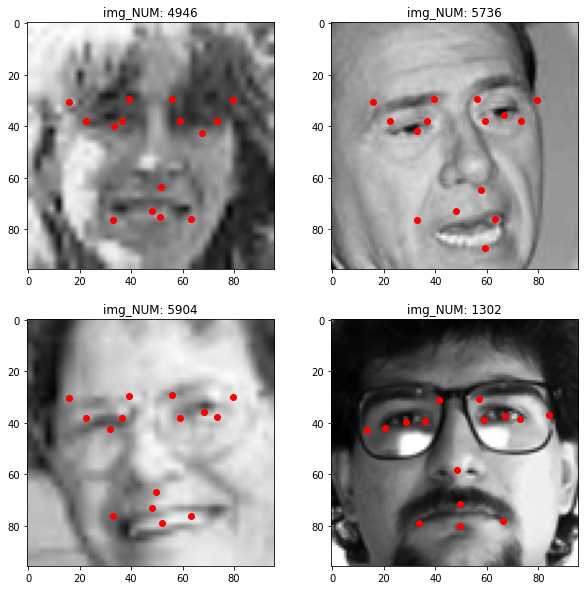

In [ ]:
fig=plt.figure(figsize=(10,10))

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)

    a = np.random.randint(len(train))

    example_img = np.array(train_img[a].split(' ')).astype(np.uint8).reshape(96,96)
    x = train_keypoints[a][0:30:2]
    y = train_keypoints[a][1:30:2]

    ax.imshow(example_img,cmap='gray')
    ax.scatter(x,y, color='r')
    ax.set_title(f'img_NUM: {a}')



## Split Train, Validate Data

In [ ]:
from sklearn.model_selection import KFold

kf=KFold(n_splits=5)

In [ ]:
train['fold'] = -1

for i,(trn_idx, val_idx) in enumerate(kf.split(train_img, train_keypoints)):
    train.loc[val_idx, 'fold'] = i

In [ ]:
train['fold'].value_counts()

3    1410
2    1410
1    1410
0    1410
4    1409
Name: fold, dtype: int64

In [ ]:
train_fold = [0,1,2,3]
val_fold = [4]

train_idx = train.loc[train.fold.isin(train_fold)].index
val_idx = train.loc[train.fold.isin(val_fold)].index 

In [ ]:
len(train_idx), len(val_idx)

(5640, 1409)

## Train,Val Dataset, DataLoader

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.torch import ToTensor

In [ ]:
class keypointsData(Dataset):
    def __init__(self, csv, transform):
        self.csv = csv.reset_index()
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self,index: int):
        train_img = self.csv['Image'].values 
        train_keypoints = self.csv.iloc[:,:-2].values
        img = np.array(train_img[index].split(' ')).astype(np.uint8).reshape(96,96)
        img = img[:,:,np.newaxis]
        img = np.repeat(img,3,2)
        keypoint = np.array(train_keypoints[index]).astype(np.float32) 

        if self.transform is not None:
            img = self.transform(image=img)['image']

        return img, keypoint


In [ ]:
train_transform=A.Compose([
                           A.Rotate(15, p=0.3),
                           ToTensor()

])

val_transfrom = A.Compose([
                           
                           ToTensor()
])

In [ ]:
train_dataset = keypointsData(csv = train.loc[train_idx], transform = train_transform)
val_dataset = keypointsData(csv = train.loc[val_idx], transform=val_transfrom)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
for input, target in train_loader:
    break

In [ ]:
input.shape,target.shape

(torch.Size([64, 3, 96, 96]), torch.Size([64, 31]))

## Make Model

In [ ]:
! pip install pretrainedmodels

In [ ]:
import pretrainedmodels

model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
in_features = model.last_linear.in_features

In [ ]:
import torch.nn as nn

In [ ]:
model.last_linear = nn.Linear(in_features, 30, bias=False)

In [ ]:
model.last_linear

Linear(in_features=512, out_features=30, bias=False)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
from sklearn.metrics import mean_squared_error

## Training

In [ ]:
model = model.to(device)
train_loss = []
best_score = 10

for epoch in tqdm_notebook(range(20)):
    model.train()

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        targets = targets[:,1:]

        optimizer.zero_grad()

        logits = model(inputs)

        loss = loss_fn(logits, targets)

        loss.backward()
        optimizer.step()

        
        train_loss.append(loss.item())

    val_loss=[]
    val_true=[]
    val_pred=[]

    model.eval()
      
    with torch.no_grad():
        for inputs,targets in val_loader:    
            inputs = inputs.to(device)
            targets = targets.to(device)

            targets = targets[:,1:]

            logits = model(inputs)

            loss = loss_fn(logits, targets)

            val_loss.append(loss.item())

            val_true.append(targets.cpu().data.numpy())
            val_pred.append(logits.cpu().data.numpy())


        val_true = np.concatenate(val_true)
        val_pred = np.concatenate(val_pred)

        final_score = mean_squared_error(val_true, val_pred)

        print(f"epochs: {epoch+1}, train_loss:{np.mean(train_loss)}, val_loss:{np.mean(val_loss)}, mse:{final_score}")

        if final_score<best_score:
            best_score=final_score

            state_dict = model.cpu().state_dict()
            model = model.to(device)

            torch.save(state_dict, 'model.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


epochs: 1, train_loss:2.0820603136266214, val_loss:2.329532180143439, mse:2.3951919078826904
epochs: 2, train_loss:1.6136080880513353, val_loss:1.5167368520861086, mse:1.5343044996261597
epochs: 3, train_loss:1.3673669819751482, val_loss:1.8832883964414182, mse:1.931986689567566
epochs: 4, train_loss:1.2351648603262526, val_loss:1.4526087201159934, mse:1.4903016090393066
epochs: 5, train_loss:1.1331370829866174, val_loss:1.783148210981618, mse:1.8238128423690796
epochs: 6, train_loss:1.0542586677976316, val_loss:2.193336564561595, mse:2.2462682723999023
epochs: 7, train_loss:1.0001645579001304, val_loss:1.844502972519916, mse:1.8775955438613892
epochs: 8, train_loss:0.964106677790706, val_loss:1.5744723340739375, mse:1.6083617210388184
epochs: 9, train_loss:0.9263180157590597, val_loss:1.3108833976413892, mse:1.3399276733398438
epochs: 10, train_loss:0.8998653363310889, val_loss:1.5238606826118801, mse:1.5628377199172974
epochs: 11, train_loss:0.8703959993371194, val_loss:1.73485506876

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

##Test Dataset, DataLoader

In [ ]:
class TestData(Dataset):
    def __init__(self,csv,transform):
        self.csv = csv
        self.transform=transform
        self.img_ids = self.csv.ImageId.values

    def __len__(self):
        return len(self.csv)

    def __getitem__(self,index: int):
        test_img = self.csv.iloc[:,1].values
        img = np.array(test_img[index].split(' ')).reshape(96,96).astype(np.uint8)
        img = img[:,:,np.newaxis]
        img = np.repeat(img, 3, 2)

        if self.transform is not None:
            img = self.transform(image=img)['image']

        return img

In [ ]:
test_transform = A.Compose([
                            ToTensor()
])

In [ ]:
test_dataset = TestData(csv=test, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)  

In [ ]:
for inputs in test_loader:
    break

In [ ]:
inputs[0].shape

torch.Size([3, 96, 96])

##Prediction

In [ ]:
model = model.to(device)
preds = []

for batch, inputs in tqdm(enumerate(test_loader)):
    model.eval()
    
    with torch.no_grad():
        inputs = inputs.to(device)

        logits = model(inputs)

        pred = np.array(logits.cpu().data)

        preds.append(pred)


28it [00:07,  3.81it/s]


In [ ]:
new_preds = np.concatenate(preds) 

In [ ]:
new_preds.shape

(1783, 30)

In [ ]:
pred_df = pd.DataFrame(new_preds) 

In [ ]:
pred_test = pd.concat([test,pred_df],axis=1)

In [5]:
pred=pd.read_csv(path+'/pred.csv')
pred2 = pd.read_csv(path+'/pred2.csv')

## Test Image Visualization

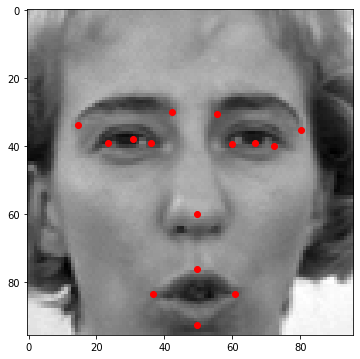

In [36]:
b=np.random.randint(len(test))

x = pred2.values[b,0:30:2]
y = pred2.values[b,1:30:2]
img = np.array(test['Image'].values[b].split(' ')).reshape(96,96).astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.scatter(x,y,c='r')
plt.show()

## Make Submission File

In [37]:
table

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [39]:
featurename = list(table['FeatureName'])
ImageId = list(table['ImageId']-1)
rowid = list(table['RowId'])

In [46]:
pred_list = list(pred2.values)

In [41]:
feature=[]

for f in list(table['FeatureName']):
    feature.append(featurename.index(f))

In [59]:
preded=[]

for x,y, in zip(ImageId, feature):
    preded.append(pred_list[x][y])

In [60]:
preded = np.round(preded,4)

In [68]:
submission['Location'] = preded

In [69]:
submission

,RowId,Location
0,1,65.8229
1,2,38.9801
2,3,30.3488
3,4,36.6492
4,5,59.5637
...,...,...
27119,27120,38.4201
27120,27121,47.7125
27121,27122,65.0973
27122,27123,48.8138


In [70]:
submission.to_csv('facial_submission.csv',index=False)